Training set size: 500
Number of images for class 'vaca_acostada': 250
Number of images for class 'vaca_de_pie': 250
Original dataset size: 500
Augmented dataset size: 1000
Epoch [1/20], Loss: 0.6781, Accuracy: 56.00%
Epoch [2/20], Loss: 0.4874, Accuracy: 76.40%
Epoch [3/20], Loss: 0.3731, Accuracy: 84.20%
Epoch [4/20], Loss: 0.1958, Accuracy: 93.80%
Epoch [5/20], Loss: 0.2405, Accuracy: 92.40%
Epoch [6/20], Loss: 0.0918, Accuracy: 96.60%
Epoch [7/20], Loss: 0.1269, Accuracy: 96.00%
Epoch [8/20], Loss: 0.0714, Accuracy: 97.00%
Epoch [9/20], Loss: 0.0512, Accuracy: 98.00%
Epoch [10/20], Loss: 0.0824, Accuracy: 97.00%
Epoch [11/20], Loss: 0.0772, Accuracy: 97.20%
Epoch [12/20], Loss: 0.0391, Accuracy: 98.20%
Epoch [13/20], Loss: 0.0302, Accuracy: 98.40%
Epoch [14/20], Loss: 0.0405, Accuracy: 98.20%
Epoch [15/20], Loss: 0.0401, Accuracy: 98.20%
Epoch [16/20], Loss: 0.0155, Accuracy: 99.60%
Epoch [17/20], Loss: 0.0164, Accuracy: 99.40%
Epoch [18/20], Loss: 0.0374, Accuracy: 98.60%
Epoch [1

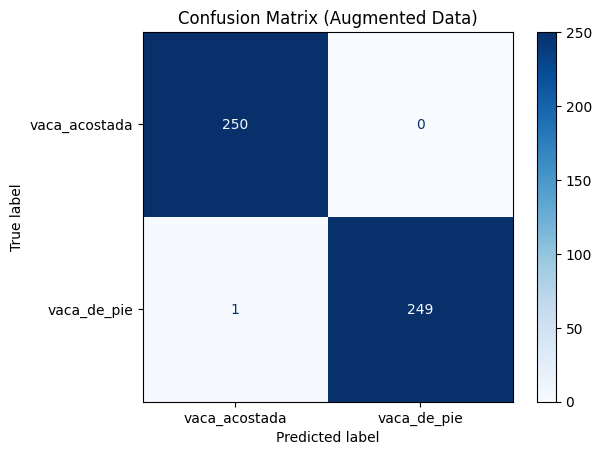

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from CowClassifier import CowClassifier
from torch.utils.data import DataLoader, ConcatDataset

# Parameters
images_per_class = 250  # Desired number of images per class
batch_size = 32




# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Dataset class
class CowDataset(Dataset):
    def __init__(self, root_dir, images_per_class=500, transform=None):
        self.root_dir = root_dir
        self.images_per_class = images_per_class
        self.transform = transform
        self.data = []
        
        # Define class labels
        self.class_labels = {'vaca_acostada': 0, 'vaca_de_pie': 1}
        self.class_counts = {label: 0 for label in self.class_labels.values()}
        
        # File extensions to consider
        valid_image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
        
        # Load images from each numbered folder (1-8)
        for folder_num in range(1, 9):
            folder_path = os.path.join(root_dir, str(folder_num))
            for class_name, label in self.class_labels.items():
                class_folder = os.path.join(folder_path, class_name)
                
                if not os.path.exists(class_folder):
                    continue
                
                for filename in os.listdir(class_folder):
                    if self.class_counts[label] >= self.images_per_class:
                        break
                    
                    if any(filename.lower().endswith(ext) for ext in valid_image_extensions):
                        img_path = os.path.join(class_folder, filename)
                        try:
                            img = Image.open(img_path)
                            if self.transform:
                                img = self.transform(img)
                            self.data.append((img, label))
                            self.class_counts[label] += 1
                        except Exception as e:
                            print(f"Error loading image {img_path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

# Instantiate datasets and dataloaders
train_dataset = CowDataset(root_dir="images", images_per_class=images_per_class, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Print dataset summary
print(f"Training set size: {len(train_dataset)}")
for class_name, label in train_dataset.class_labels.items():
    print(f"Number of images for class '{class_name}': {train_dataset.class_counts[label]}")




# Additional data augmentation transformations
# Adjusted augmentations
augment_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Custom Dataset with Augmentation (corrected) 
class AugmentedCowDataset(Dataset):
    def __init__(self, original_dataset, augment_transform):
        self.original_dataset = original_dataset
        self.augment_transform = augment_transform

    def __len__(self):
        # Original dataset length times two (for each augmented copy)
        return len(self.original_dataset) * 2

    def __getitem__(self, idx):
        original_idx = idx // 2
        image, label = self.original_dataset[original_idx]
        
        
        # Convert tensor back to PIL for augmentation
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        
        # Apply augmentation on every second image
        if idx % 2 == 1:
            image = self.augment_transform(image)
        else:
            # Convert original image to tensor (if not already)
            image = transform(image)
            
        return image, label

# Instantiate augmented dataset
augmented_dataset = AugmentedCowDataset(train_dataset, augment_transform)

# Create a DataLoader for the augmented dataset
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

# Print summary
print(f"Original dataset size: {len(train_dataset)}")
print(f"Augmented dataset size: {len(augmented_dataset)}")


# Set device
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
model = CowClassifier().to(device)

# Loss and optimizer
# Manually define weights for each class 
manual_weights = torch.tensor([3.0, 2.0], dtype=torch.float).to(device)

# Define the loss function with manual weights
criterion = nn.CrossEntropyLoss(weight=manual_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds


epochs=15
# Train on augmented data
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

# Evaluate the model on the augmented dataset
train_accuracy, train_labels, train_preds = evaluate(model, train_loader)
print(f"Training Accuracy on Augmented Data: {train_accuracy:.2f}%")

# Display classification report and confusion matrix
print("\nClassification Report on Augmented Data:")
print(classification_report(train_labels, train_preds, target_names=train_dataset.class_labels.keys()))

cm = confusion_matrix(train_labels, train_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_labels.keys())
disp.plot(cmap= plt.cm.Blues)
plt.title('Confusion Matrix (Augmented Data)')
plt.show()



In [3]:

torch.save(model, '../models/cow_class_model.pth')


In [12]:
torch.save(model.state_dict(), "../models/cow_class_model_state.pth")